In [1]:
# Import libraries.
import cv2                              # For image processing.
import gym                              # Interface for interacting with the environment.
import imageio                          # Used to generate GIFs.
import matplotlib.pyplot as plt         # Plot images and statistics.
import numpy as np                      # Work with matrices efficiently.
import torch                            # Includes everything we need for the neural network.
import datetime                         # Used to get the current timestamp.
import random                           # Functions for non-deterministic behaviour.
import os                               # Used to create new directories.
import time                             # Gives us the current time.
from skimage.transform import resize    # Resizes images.

In [2]:
# A few checks to see if we can use a GPU and which GPUs are available.
print("Cuda available: {}".format(torch.cuda.is_available()))
for i in range(torch.cuda.device_count()):
    print("Device name: {}".format(torch.cuda.get_device_name(i)))

Cuda available: True
Device name: NVIDIA GeForce GTX 1060 6GB


In [3]:
class ReplayBuffer:
    """The replay buffer stores the observed images, performed actions, rewards and whether the episode terminated.
       We can use it to randomly sample previously observed states/experiences."""
    
    def __init__(self, capacity, image_height, image_width, image_history_length, batch_size, device):
        self.capacity = capacity
        self.image_height = image_height
        self.image_width = image_width
        self.image_history_length = image_history_length
        self.batch_size = batch_size
        self.ptr = 0      # Pointer/current index.
        self.size = 0     # Current size of the buffer.

        # Pre-allocate tensors so we can see beforehand whether we have enough memory or not.
        # Data from environment.
        self.images = torch.empty((capacity, image_height, image_width), dtype=torch.float, device='cpu')
        self.actions = torch.empty(capacity, dtype=torch.int64, device=device)
        self.rewards = torch.empty(capacity, dtype=torch.float, device=device)
        self.done = torch.empty(capacity, dtype=torch.bool, device=device)
        
        # Buffer specific tensors.
        self.states = torch.empty((self.batch_size, self.image_history_length, 
                                   self.image_height, self.image_width), dtype=torch.float, device=device)
        self.next_states = torch.empty((self.batch_size, self.image_history_length, 
                                       self.image_height, self.image_width), dtype=torch.float, device=device)
        self.indices = torch.empty(batch_size, dtype=torch.long, device='cpu')
        
    def put(self, observation, action, reward, done):
        # Add experience to the buffer.
        self.images[self.ptr] = observation
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.done[self.ptr] = done
        
        self.size = min(self.size + 1, self.capacity)
        self.ptr = (self.ptr + 1) % self.capacity
        
    def _get_indices(self):
        # Get valid indices to reference experiences.
        for i in range(self.batch_size):
            while True:
                index = random.randint(self.image_history_length, self.size - 1)
                if index >= self.ptr and index - self.image_history_length <= self.ptr:
                    # We can not create a stack of images.
                    continue
                if self.done[index - self.image_history_length:index].any():
                    # Stack contains experiences from two different episodes.
                    continue
                break
            self.indices[i] = index
        
    def get(self):
        self._get_indices()
        
        # Create stacked batches of images.
        for i, batch_idx in enumerate(self.indices):
            self.states[i] = self.images[batch_idx-self.image_history_length:batch_idx, ...]
            self.next_states[i] = self.images[batch_idx-self.image_history_length+1:batch_idx+1, ...]
        return (self.states,
                self.actions[self.indices],
                self.rewards[self.indices],
                self.next_states,
                self.done[self.indices])

In [4]:
class EpsilonSchedule:
    """Calculates the exploration probability (epsilon) for a given timestep. Proposed by Deepmind."""
    
    def __init__(self, start_learning, eps_final, eps_start, frame_decay):
        self.eps_start = eps_start
        self.start_learning = start_learning
        self.eps_final = eps_final
        self.frame_decay = frame_decay
    
    def get_epsilon(self, timestep, evaluation=False):
        if evaluation:
            # No exploration during evaluation -> we want to measure model performance.
            return 0.0
        if timestep < self.start_learning:
            return self.eps_start
        else:
            eps = self.eps_start - ((timestep - self.start_learning) / self.frame_decay) * (self.eps_start - self.eps_final)
            return max(self.eps_final, eps)

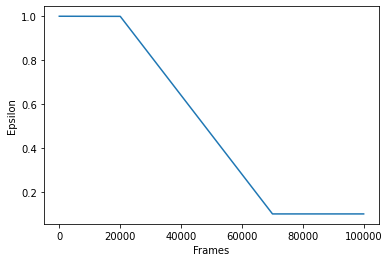

In [5]:
es = EpsilonSchedule(20000, 0.1, 1.0, 50000)
x = []
y = []
for t in range(100000):
    x.append(t)
    y.append(es.get_epsilon(t))
plt.xlabel('Frames')
plt.ylabel('Epsilon')
plt.plot(x, y)
plt.show()

In [6]:
def get_action(network, state, epsilon):
    if random.random() > epsilon:
        # Choose the best action accordingly to the model's prediction.
        with torch.no_grad():
            q_value = network(torch.unsqueeze(state, 0))
            return q_value.argmax().item()
    else:
        # Choose a random action.
        return random.choice([0,2,3])

In [7]:
def preprocess(image, image_height, image_width):
    """Improve computation speed by preprocessing the image. Transforms to gray scale, crops, resizes and normalizes
       the image. Except for normalizing, Deepmind does the same."""
    gray = 0.2989 * image[:,:,0] + 0.5870 * image[:,:,1] + 0.1140 * image[:,:,2]
    gray = gray[34:194, 0:160]
    gray = cv2.resize(gray, dsize=(image_height, image_width), interpolation=cv2.INTER_NEAREST)
    return gray / 255

Original shape: (210, 160, 3)
Shape after preprocessing: (84, 84)
Possible actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT']


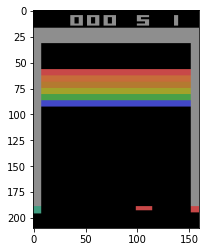

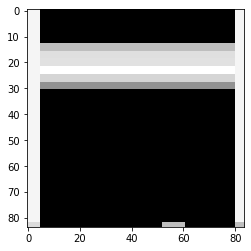

In [8]:
env = gym.make('BreakoutDeterministic-v4')
print("Original shape:", env.reset().shape)

test_image = preprocess(env.reset(), 84, 84)
print("Shape after preprocessing:", test_image.shape)

print("Possible actions:", env.unwrapped.get_action_meanings())

plt.imshow(env.reset())
plt.show()
plt.imshow(test_image, interpolation='nearest', cmap="gray")
plt.show()

In [9]:
class BreakoutWrapper:
    """Adds additional functionality to the Atari environment."""
    
    def __init__(self, image_height, image_width, image_history_length, noop_max):
        self.environment = gym.make('BreakoutDeterministic-v4')    # Gym environment.
        self.number_actions = self.environment.action_space.n      # 4 actions for Breakout.
        self.previous_lives = 0                                    # Stores the number of lives of the previous observation.
        self.image_height = image_height
        self.image_width = image_width
        self.image_history_length = image_history_length           # Number of images to stack.
        self.state = None                                          # State will already contain a stack of images.
        self.noop_max = noop_max                                   # Number of no operations after a reset.
    
    def reset(self, evaluation=False):
        observation = self.environment.reset()
        self.previous_lives = 0
        
        # Perform no actions.
        if evaluation:
            for _ in range(random.randint(1, self.noop_max)):
                observation, _, _, _ = self.environment.step(1)
                
        # Preprocess observation and create state matrix by repeating that image.
        observation_preprocessed = preprocess(observation, self.image_height, self.image_width)
        self.state = torch.FloatTensor(observation_preprocessed).repeat(self.image_history_length, 1, 1)
        return True
        
    
    def step(self, action):
        observation, reward, done, info = self.environment.step(action)
        
        if info["lives"] < self.previous_lives:
            live_lost = True
        else:
            live_lost = done
        self.previous_lives = info["lives"]
        
        # Preprocess new observation and add it to the image stack and remove oldest image; return data.
        observation_processed = torch.FloatTensor(preprocess(observation, self.image_height, self.image_width)).unsqueeze(0)
        self.state = torch.cat([self.state[1:,:,:], observation_processed], 0)
        return observation_processed, reward, done, live_lost, observation

In [18]:
class DQNNetwork(torch.nn.Module):
    """The neural network architecture. This one shares similarities with the one proposed by Deepmind.
       However, I additionally added batch normalization."""

    def __init__(self, num_actions, image_history_length, device):
        super(DQNNetwork, self).__init__()
        self.device = device

        self.layers = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=image_history_length, out_channels=16,
                            kernel_size=(8, 8), stride=4, padding="valid"),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=16, out_channels=32,
                            kernel_size=(4, 4), stride=2, padding="valid"),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=2592, out_features=256),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=256, out_features=num_actions)
        )
    
    def forward(self, x):
        x = x.to(self.device)
        return self.layers(x)  

In [11]:
def clip_reward(reward):
    """Proposed by Deepmind. Clips reward to {-1, 0, 1}. Improves the agent performance since it can
       not differentiate between different reward magnitudes. Used in training mode only."""
    if reward > 0:
        return 1
    elif reward == 0:
        return 0
    else:
        return -1

In [12]:
def generate_gif(frame_number, frames_for_gif, reward, path):
    """Function taken from: https://github.com/fg91/Deep-Q-Learning/blob/master/DQN.ipynb. Generates a GIF to
       visually evaluate a model."""
    for idx, frame_idx in enumerate(frames_for_gif): 
        frames_for_gif[idx] = resize(frame_idx, (420, 320, 3), 
                                     preserve_range=True, order=0).astype(np.uint8)
        
    imageio.mimsave(f'{path}{"ATARI_frame_{0}_reward_{1}.gif".format(frame_number, reward)}', 
                    frames_for_gif, duration=1/30)

In [19]:
class DQN:
    """Implements the Deep Q-Learning algorithm."""
    
    def __init__(self, environment, scheduler, buffer, image_height, image_width, image_history_length, learning_rate,
                 discount, device):
        self.environment = environment
        self.scheduler = scheduler
        self.replay_buffer = buffer
        self.learning_rate = learning_rate
        self.discount = discount
        self.device = device        

        # Define policy and target network.
        self.net = DQNNetwork(self.environment.number_actions, image_history_length, self.device).to(self.device)
        self.target_net = DQNNetwork(self.environment.number_actions, image_history_length, self.device).to(self.device)
        self.target_net.load_state_dict(self.net.state_dict())
        self.target_net.eval()
        
        # Define optimizer and loss function.
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=learning_rate)    # Deepmind used RMSProp.
        self.loss = torch.nn.HuberLoss()
    
    def _backpropagation(self):
        """Calculates the loss and optimizes the layers."""
        
        # Get random batch samples from replay buffer.
        observations, actions, rewards, next_observations, dones = self.replay_buffer.get()
        
        # Get the q-values of the policy network's prediction.
        q_values = self.net(observations)
        q_values = q_values.gather(1, actions.unsqueeze(1))

        # Get the target network's prediction of the next observations.
        future_rewards = self.target_net(next_observations)
        
        # Calculate the Bellman equation.
        updated_q_values = rewards + self.discount * future_rewards.max(1)[0] * ~(dones)

        # Calculate the loss between the policy network prediction and the Bellman equation q-values.
        loss = self.loss(q_values.squeeze(1), updated_q_values)
        
        # Backpropagation.
        self.optimizer.zero_grad()
        loss.backward()
        
        # Clip gradients to avoid exploding gradients.
        torch.nn.utils.clip_grad_norm_(self.net.parameters(), 1.0)
        
        # Update weights of all trainable layers and return loss.
        self.optimizer.step()
        return loss.item()

    def learn(self, max_images, update_after, max_images_episode, sync_target, evaluate_after):
        number_observations = 0    # Number of total seen images.
        rewards = []               # List with episode rewards.
        loss_list = []             # List of mean loss after every 10 episodes.
        print("Timestamp/Episode/Number Observations/Mean of last 100 rewards/Loss")
        while number_observations < max_images:
            
            # Training loop.
            epoch_observations = 0    # Images until we evaluate the model.
            while epoch_observations < evaluate_after:
                life_lost = self.environment.reset()
                episode_reward = 0
                for _ in range(max_images_episode):
                    # Episode loop.
                    # Get action.
                    if life_lost:
                        action = 1
                    else:
                        epsilon = self.scheduler.get_epsilon(number_observations)
                        action = get_action(self.net, self.environment.state, epsilon)

                    # Execute action, fetch the data and store experience in replay buffer.
                    next_observation, reward, done, life_lost, _ = self.environment.step(action)
                    self.replay_buffer.put(next_observation, action, clip_reward(reward), life_lost)
                    
                    # Update loop specific variables.
                    number_observations += 1
                    epoch_observations += 1
                    episode_reward += reward
                    

                    if number_observations % update_after == 0 and number_observations > self.scheduler.start_learning:
                        loss = self._backpropagation()
                        loss_list.append(loss)
                        
                    if number_observations % sync_target == 0 and number_observations > self.scheduler.start_learning:
                        # Synchronize target network with policy network.
                        self.target_net.load_state_dict(self.net.state_dict())
                    
                    if done:
                        rewards.append(episode_reward)
                        
                        # Print and save statistics every 10 episodes.
                        if len(rewards) % 10 == 0:
                            timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%d.%m.%Y %H:%M:%S')
                            print(str(timestamp), len(rewards), number_observations, np.mean(rewards[-100:]),
                                  np.mean(loss_list))
                            with open('output\\data.txt', 'a') as file:
                                print(str(timestamp), len(rewards), number_observations, 
                                      np.mean(rewards[-100:]), np.mean(loss_list), file=file)
                            loss_list = []
                        break
                        
            # Evaluation loop.
            done = True          # Episode over?
            gif = True           # Create a GIF?
            life_lost = environment.reset(evaluation=True)
            gif_images = []      # List with images for GIF.
            eval_rewards = []    # List with episode rewards.
            episode_reward = 0
            
            for _ in range(10000):       
                # Get action.
                if life_lost:
                    action = 1
                else:
                    epsilon = self.scheduler.get_epsilon(number_observations, evaluation=True)
                    action = get_action(self.net, self.environment.state, epsilon)

                # Execute action, fetch the data and accumulate the episode reward.
                _, reward, done, life_lost, next_observation = self.environment.step(action)
                episode_reward += reward

                if gif: 
                    gif_images.append(next_observation)
                if done:
                    eval_rewards.append(episode_reward)
                    episode_reward = 0
                    gif = False   # Save only the first game of the evaluation as a GIF.
                    environment.reset(evaluation=True)
                     
            # Print and save statistics of this evaluation. Also generate a GIF of the model playing.
            timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%d.%m.%Y %H:%M:%S')
            print("Evaluation score:", str(timestamp), str(number_observations), np.mean(eval_rewards))
            if len(eval_rewards) != 0:
                generate_gif(number_observations, gif_images, eval_rewards[0], "output\\")
            with open('output\\dataEval.txt', 'a') as eval_file:
                print(str(timestamp), number_observations, np.mean(eval_rewards), file=eval_file)
            gif_images = []
            
            # Save the policy network parameters.
            torch.save(self.net.state_dict(), "model\\model_{}.pt".format(str(number_observations)))

In [21]:
# Jupyter doesn't release the memory by default, so we have to take care of it.
# Execute this cell, if you want to restart training after an interrupt.
import gc
gc.collect()
torch.cuda.empty_cache()
del buffer
del environment
del scheduler
del dqn

NameError: name 'buffer' is not defined

In [22]:
# Use CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: " + str(device))

# Environment hyperparameters:
image_height = 84             # Deepmind used a image resolution of 84x84.
image_width = 84              #
image_history_length = 4      # Number of stacked images, which represent one state and are passed to the NN.
noop_max = 10                 # Number of idle actions on environment reset. Not in paper but found in atari_wrappers.py.
environment = BreakoutWrapper(image_height, image_width, image_history_length, noop_max)

# Scheduler hyperparameters:
start_learning = 60000        # Frame at which the epsilon starts decaying. Used to exploration and fill the buffer.
epsilon_start = 1.0           # Initial epsilon (1.0 is maximum). Same as proposed by Deepmind.
epsilon_final = 0.1           # Lowest possible epsilon.
frame_decay = 1000000         # Number of frames until the initial epsilon decays to the final epsilon. Deepmind used 1000000
scheduler = EpsilonSchedule(start_learning, epsilon_final, epsilon_start, frame_decay)

# Buffer hyperparameters:
capacity = 400000             # Replay buffer capacity. Deepmind used 1000000, which results in memory issues.
batch_size = 32               # Number of samples used during optimization. Same as Deepmind.
buffer = ReplayBuffer(capacity, image_height, image_width, image_history_length, batch_size, device)

# DQN hyperparameters:
learning_rate = 0.0001        # Learning rate for the optimizer. Deepmind doesn't specify the learning rate.
sync_target = 10000           # Sychronize target and policy network after x frames.
max_images = 20000000         # Maximum number of images we want to train on (termination criteria).
max_images_episode = 18000    # End episode after x frames.
update_after = 4              # Optimize model after x frames.
discount = 0.99               # Discount factor to calculate Q value.
evaluate_after = 200000       # Evaluate model after x frames.
dqn = DQN(environment, scheduler, buffer, image_height, image_width,
          image_history_length, learning_rate, discount, device)

Device: cuda


In [21]:
# Create folders and delete artifacts.
if not os.path.exists("model"):
    os.mkdir("model")
if not os.path.exists("output"):
    os.mkdir("output")
if os.path.exists(os.path.join("output", "data.txt")):
    os.remove(os.path.join("output", "data.txt"))
if os.path.exists(os.path.join("output", "dataEval.txt")):
    os.remove(os.path.join("output", "dataEval.txt"))

In [23]:
# Start learning.
dqn.learn(max_images, update_after, max_images_episode, sync_target, evaluate_after)

Timestamp/Episode/Number Observations/Mean of last 100 rewards/Loss
16.02.2022 15:49:09 10 1517 0.5 nan
16.02.2022 15:49:10 20 3080 0.6 nan
16.02.2022 15:49:12 30 4637 0.6333333333333333 nan
16.02.2022 15:49:13 40 6219 0.675 nan
16.02.2022 15:49:15 50 7896 0.76 nan
16.02.2022 15:49:17 60 9456 0.75 nan
16.02.2022 15:49:18 70 10889 0.7 nan
16.02.2022 15:49:20 80 12551 0.7375 nan
16.02.2022 15:49:21 90 14069 0.7333333333333333 nan
16.02.2022 15:49:23 100 15795 0.78 nan
16.02.2022 15:49:24 110 17329 0.79 nan
16.02.2022 15:49:26 120 18942 0.81 nan
16.02.2022 15:49:28 130 20402 0.79 nan
16.02.2022 15:49:29 140 22044 0.81 nan
16.02.2022 15:49:31 150 23597 0.76 nan
16.02.2022 15:49:32 160 25318 0.8 nan
16.02.2022 15:49:34 170 26744 0.79 nan
16.02.2022 15:49:35 180 28246 0.74 nan
16.02.2022 15:49:37 190 29825 0.76 nan
16.02.2022 15:49:39 200 31439 0.73 nan
16.02.2022 15:49:40 210 33079 0.78 nan
16.02.2022 15:49:42 220 34879 0.83 nan
16.02.2022 15:49:44 230 36759 0.94 nan
16.02.2022 15:49:45 240

16.02.2022 16:02:46 1520 244520 1.22 0.0011273758657689879
16.02.2022 16:02:53 1530 246101 1.21 0.0011388125522519001
16.02.2022 16:03:00 1540 247864 1.28 0.0009152846555696756
16.02.2022 16:03:06 1550 249520 1.23 0.0010501515550814752
16.02.2022 16:03:13 1560 251122 1.15 0.0013996260366002389
16.02.2022 16:03:19 1570 252693 1.12 0.0013820858446465872
16.02.2022 16:03:26 1580 254387 1.1 0.0011885286704341256
16.02.2022 16:03:33 1590 256108 1.12 0.0009836272667151317
16.02.2022 16:03:40 1600 257699 1.07 0.0010022946139256546
16.02.2022 16:03:47 1610 259542 1.11 0.000994774700290677
16.02.2022 16:03:54 1620 261371 1.14 0.0014480571069733516
16.02.2022 16:04:02 1630 263324 1.25 0.001044053256413247
16.02.2022 16:04:10 1640 265154 1.28 0.0010359668343188342
16.02.2022 16:04:17 1650 266763 1.23 0.0010341743451425288
16.02.2022 16:04:23 1660 268472 1.28 0.0010002733030216116
16.02.2022 16:04:33 1670 270782 1.49 0.0011437595987296926
16.02.2022 16:04:41 1680 272854 1.6 0.0012497881286776208
1

16.02.2022 16:25:56 2920 574429 4.51 0.0031525982474365642
16.02.2022 16:26:08 2930 577306 4.38 0.003275038988746558
16.02.2022 16:26:22 2940 580696 4.37 0.0033988710670629823
16.02.2022 16:26:35 2950 583709 4.53 0.0032693245854002397
16.02.2022 16:26:49 2960 586907 4.72 0.003302248812732852
16.02.2022 16:27:06 2970 590852 5.0 0.0032596515343048475
16.02.2022 16:27:21 2980 594396 5.19 0.003456688040744463
16.02.2022 16:27:35 2990 597797 5.35 0.0033333295185858495
Evaluation score: 16.02.2022 16:28:01 600320 20.0
16.02.2022 16:28:10 3000 600990 5.43 0.0035000394474768094
16.02.2022 16:28:24 3010 604357 5.5 0.003617448341152564
16.02.2022 16:28:36 3020 607111 5.62 0.003499875700241361
16.02.2022 16:28:53 3030 611126 5.95 0.0035270212647301956
16.02.2022 16:29:10 3040 615122 6.14 0.003807917056074767
16.02.2022 16:29:26 3050 618812 6.28 0.0035954383315096226
16.02.2022 16:29:41 3060 622240 6.38 0.0038667453452673074
16.02.2022 16:29:56 3070 625658 6.22 0.003916306207891645
16.02.2022 16:3

Evaluation score: 16.02.2022 17:28:49 1402453 59.0
16.02.2022 17:29:44 4280 1411539 43.38 0.007698433373581872
16.02.2022 17:30:37 4290 1422465 43.47 0.007307807049212233
16.02.2022 17:31:30 4300 1433503 44.04 0.00737164597856215
16.02.2022 17:32:29 4310 1445537 45.02 0.007603075407405503
16.02.2022 17:33:25 4320 1457166 46.1 0.008056946980028814
16.02.2022 17:34:28 4330 1470174 47.2 0.00822354088828648
16.02.2022 17:35:20 4340 1480926 47.78 0.008449512253372675
16.02.2022 17:36:13 4350 1491808 48.67 0.008061959657440552
16.02.2022 17:37:11 4360 1503839 49.57 0.008221374528939701
16.02.2022 17:38:09 4370 1515711 50.23 0.008186786503832588
16.02.2022 17:39:07 4380 1527748 50.64 0.008547012826104485
16.02.2022 17:40:01 4390 1538821 51.43 0.00882588317350288
16.02.2022 17:41:01 4400 1551113 52.51 0.008399227049949998
16.02.2022 17:41:58 4410 1562890 52.05 0.00792470084015013
16.02.2022 17:43:00 4420 1575423 52.85 0.007836028385485002
16.02.2022 17:43:57 4430 1587217 52.02 0.00828184952504

16.02.2022 19:40:59 5570 3063313 111.7 0.012720081194205896
16.02.2022 19:41:54 5580 3075606 107.74 0.01286057866565014
16.02.2022 19:43:03 5590 3091346 108.38 0.012830662728154741
16.02.2022 19:44:12 5600 3106927 111.8 0.013755170602634769
16.02.2022 19:45:14 5610 3120867 115.53 0.014125357618404437
16.02.2022 19:46:13 5620 3134118 110.54 0.014348793393269423
16.02.2022 19:47:12 5630 3147424 113.68 0.014194845710622121
16.02.2022 19:48:12 5640 3161062 114.63 0.014762759759918895
16.02.2022 19:49:09 5650 3173923 114.19 0.014554210240166189
16.02.2022 19:50:09 5660 3187364 116.68 0.01560116506764115
16.02.2022 19:51:01 5670 3199055 116.13 0.015540626191307487
Evaluation score: 16.02.2022 19:52:02 3209150 280.0
16.02.2022 19:52:33 5680 3212114 116.08 0.017313172486945874
16.02.2022 19:53:32 5690 3225266 114.01 0.016334188404234427
16.02.2022 19:54:30 5700 3238301 108.96 0.016802806795163074
16.02.2022 19:55:39 5710 3253940 108.23 0.01598138260762886
16.02.2022 19:56:40 5720 3267736 111.7

16.02.2022 22:04:37 6850 4902577 147.75 0.029790413350584057
16.02.2022 22:05:39 6860 4916501 143.6 0.030708641086054093
16.02.2022 22:06:53 6870 4932221 149.87 0.029938952631759042
16.02.2022 22:08:01 6880 4946364 152.67 0.030927592078505643
16.02.2022 22:09:11 6890 4961017 156.14 0.031089656459423885
16.02.2022 22:10:15 6900 4974717 156.03 0.03360513426281893
16.02.2022 22:11:22 6910 4989186 154.58 0.031219317513794316
16.02.2022 22:12:28 6920 5004034 157.53 0.03144029920368384
Evaluation score: 16.02.2022 22:13:38 5014938 382.5
16.02.2022 22:14:07 6930 5016737 158.74 0.030656142392980465
16.02.2022 22:15:27 6940 5033177 165.72 0.030774753830234754
16.02.2022 22:16:39 6950 5048072 162.57 0.03310198009598207
16.02.2022 22:17:48 6960 5062227 165.27 0.030324925702758063
16.02.2022 22:18:57 6970 5076434 158.66 0.028830273443442845
16.02.2022 22:19:59 6980 5089079 154.27 0.029336986127325704
16.02.2022 22:21:13 6990 5104395 152.35 0.02821040602533945
16.02.2022 22:22:27 7000 5119574 156.5

17.02.2022 00:31:36 8130 6767397 149.1 0.027206243591330524
17.02.2022 00:32:45 8140 6782737 143.67 0.026657918232372894
17.02.2022 00:33:50 8150 6797035 131.51 0.02689835251793401
17.02.2022 00:34:58 8160 6811979 132.95 0.025769025791457373
Evaluation score: 17.02.2022 00:35:49 6819545 399.0
17.02.2022 00:36:34 8170 6826064 136.82 0.02749449582639574
17.02.2022 00:37:37 8180 6840317 134.38 0.02755277972015464
17.02.2022 00:38:40 8190 6854431 135.42 0.026267335710103586
17.02.2022 00:39:51 8200 6870359 133.45 0.025686786954077397
17.02.2022 00:40:50 8210 6883711 132.3 0.02619460463917124
17.02.2022 00:41:53 8220 6897955 141.91 0.02566619136215629
17.02.2022 00:42:57 8230 6912309 142.08 0.02582350872598711
17.02.2022 00:44:00 8240 6926648 144.34 0.025677446023602626
17.02.2022 00:44:47 8250 6937112 143.27 0.025502696093449524
17.02.2022 00:45:56 8260 6952761 150.11 0.026262828466484364
17.02.2022 00:46:58 8270 6966546 146.65 0.02618766114697724
17.02.2022 00:48:00 8280 6980573 143.07 0.

17.02.2022 02:54:09 9410 8623922 156.09 0.02728763399690593
Evaluation score: 17.02.2022 02:54:40 8627111 175.66666666666666
17.02.2022 02:55:42 9420 8637253 157.9 0.027282961611679295
17.02.2022 02:56:39 9430 8650179 156.19 0.027665395521157005
17.02.2022 02:57:48 9440 8665680 148.74 0.027895836139823934
17.02.2022 02:58:42 9450 8677957 139.65 0.026263244261339417
17.02.2022 02:59:52 9460 8693592 146.2 0.02709852190889336
17.02.2022 03:00:47 9470 8706065 144.86 0.02640327782032777
17.02.2022 03:01:50 9480 8720247 143.11 0.025525071529956596
17.02.2022 03:02:57 9490 8735437 142.06 0.0281045096923939
17.02.2022 03:03:59 9500 8749310 135.86 0.02674477387010469
17.02.2022 03:05:02 9510 8763351 134.34 0.02811786404494435
17.02.2022 03:06:02 9520 8776873 130.37 0.027680924850568632
17.02.2022 03:07:08 9530 8791765 134.88 0.02672013887837119
17.02.2022 03:08:04 9540 8804624 131.53 0.02579493834879713
17.02.2022 03:09:03 9550 8817820 132.38 0.026732471828846072
Evaluation score: 17.02.2022 03

17.02.2022 05:11:09 10680 10404501 134.99 0.027778419060561735
17.02.2022 05:12:18 10690 10420034 136.7 0.025739030705261453
17.02.2022 05:13:18 10700 10433650 135.39 0.027717041726776515
Evaluation score: 17.02.2022 05:13:34 10433650 355.0
17.02.2022 05:15:00 10710 10449200 140.04 0.02507267455213369
17.02.2022 05:15:54 10720 10461394 133.35 0.02776993017088655
17.02.2022 05:16:58 10730 10475756 138.54 0.027813262680751114
17.02.2022 05:18:04 10740 10490649 145.13 0.02691661962414305
17.02.2022 05:19:16 10750 10506677 157.88 0.027196564673890512
17.02.2022 05:20:24 10760 10521891 163.91 0.026982194457925334
17.02.2022 05:21:30 10770 10536785 170.98 0.026001835436856316
17.02.2022 05:22:39 10780 10552343 169.07 0.027156104121822264
17.02.2022 05:23:37 10790 10565528 163.79 0.02705683599057821
17.02.2022 05:24:34 10800 10578304 165.08 0.027422768414875173
17.02.2022 05:25:36 10810 10592370 160.41 0.028574878135677512
17.02.2022 05:26:41 10820 10607054 169.95 0.028312917417070052
17.02.2

17.02.2022 07:25:37 11920 12147694 140.5 0.02539462098372385
17.02.2022 07:26:36 11930 12160746 142.02 0.026276634557034512
17.02.2022 07:27:42 11940 12175508 146.11 0.026756674028985784
17.02.2022 07:28:45 11950 12189451 153.41 0.025676801803600647
17.02.2022 07:29:51 11960 12204265 155.01 0.025764476451328826
17.02.2022 07:30:48 11970 12217010 153.66 0.02744388328838131
17.02.2022 07:31:56 11980 12232032 158.96 0.025354989264496374
Evaluation score: 17.02.2022 07:32:46 12239637 402.0
17.02.2022 07:33:31 11990 12245300 149.35 0.028022253630327086
17.02.2022 07:34:36 12000 12259752 152.55 0.02641029340848368
17.02.2022 07:35:45 12010 12275263 154.26 0.02620742781464777
17.02.2022 07:36:54 12020 12290673 161.03 0.02565611846368666
17.02.2022 07:38:01 12030 12305749 166.42 0.025398512025622953
17.02.2022 07:39:02 12040 12319422 164.19 0.025641593005088028
17.02.2022 07:40:09 12050 12334215 163.65 0.02712565574692003
17.02.2022 07:41:17 12060 12349331 162.09 0.026683835354897326
17.02.202

17.02.2022 09:38:56 13160 13869730 141.56 0.024699034613662577
17.02.2022 09:40:08 13170 13885538 147.48 0.022615263413407874
17.02.2022 09:41:13 13180 13899133 146.75 0.021988752630520608
17.02.2022 09:42:09 13190 13911082 143.42 0.02348575537113406
17.02.2022 09:43:05 13200 13923247 140.55 0.024045003595408537
17.02.2022 09:44:14 13210 13936630 140.53 0.023247878464594043
17.02.2022 09:45:29 13220 13950707 142.78 0.024307509629077295
17.02.2022 09:46:40 13230 13964016 140.36 0.023603844885166418
17.02.2022 09:47:42 13240 13975755 135.75 0.023418373069437073
17.02.2022 09:48:52 13250 13988909 139.89 0.022353421532690262
17.02.2022 09:50:07 13260 14003169 136.14 0.023933358230565374
17.02.2022 09:51:14 13270 14016223 128.5 0.02420507051784761
17.02.2022 09:52:30 13280 14031198 131.45 0.024397507943699295
17.02.2022 09:53:34 13290 14044143 130.8 0.023947867509275526
Evaluation score: 17.02.2022 09:53:52 14044143 nan
17.02.2022 09:55:00 13300 14057650 131.14 0.023866558211960664
17.02.20

17.02.2022 12:04:14 14410 15583629 128.65 0.02517085850041026
17.02.2022 12:05:12 14420 15596603 124.85 0.026617813633061024
17.02.2022 12:06:10 14430 15609385 124.01 0.02678566888184986
17.02.2022 12:07:08 14440 15622340 122.83 0.028068662260297608
17.02.2022 12:08:08 14450 15635814 125.81 0.02740574719135029
Evaluation score: 17.02.2022 12:09:27 15649743 300.0
17.02.2022 12:09:50 14460 15651191 126.44 0.026227573861284898
17.02.2022 12:10:53 14470 15665181 132.82 0.026494275366918334
17.02.2022 12:11:48 14480 15677455 129.76 0.026607272089399808
17.02.2022 12:12:56 14490 15692545 137.14 0.027238525682906013
17.02.2022 12:14:02 14500 15707332 139.01 0.027763014655286425
17.02.2022 12:15:03 14510 15720942 133.54 0.02621098250497805
17.02.2022 12:16:15 14520 15737138 141.89 0.02731073268385713
17.02.2022 12:17:23 14530 15752354 149.62 0.025698531429933582
17.02.2022 12:18:28 14540 15766462 154.38 0.02649720751618117
17.02.2022 12:19:30 14550 15780120 158.09 0.027853673608874082
17.02.20

17.02.2022 14:17:31 15650 17289429 132.68 0.02676161460481584
17.02.2022 14:18:33 15660 17303270 135.1 0.02641450153395259
17.02.2022 14:19:27 15670 17315311 136.08 0.027002753510775718
17.02.2022 14:20:29 15680 17328717 136.04 0.02539702660981638
17.02.2022 14:21:29 15690 17342214 137.13 0.025132748217435934
17.02.2022 14:22:32 15700 17356361 143.98 0.02495967437704598
17.02.2022 14:23:30 15710 17368673 141.19 0.02470128978130573
17.02.2022 14:24:35 15720 17382799 141.78 0.02563903297619307
17.02.2022 14:25:35 15730 17396223 141.33 0.02427671229999892
17.02.2022 14:26:37 15740 17410100 137.73 0.024149533680013463
17.02.2022 14:27:46 15750 17425554 150.08 0.025412613243491918
17.02.2022 14:28:50 15760 17439812 150.63 0.025943837505680356
17.02.2022 14:30:01 15770 17455742 159.46 0.025935214653613287
Evaluation score: 17.02.2022 14:30:23 17456936 nan
17.02.2022 14:31:22 15780 17469934 161.31 0.025137431247857018
17.02.2022 14:32:18 15790 17482232 161.53 0.025214354461210408
17.02.2022 1

17.02.2022 16:37:59 16900 19028595 152.48 0.023263363092368188
17.02.2022 16:39:01 16910 19041440 145.5 0.023999411066553924
17.02.2022 16:40:14 16920 19056341 154.49 0.02358830917367224
Evaluation score: 17.02.2022 16:41:08 19063813 302.0
17.02.2022 16:41:55 16930 19069680 157.49 0.024227665791900988
17.02.2022 16:43:10 16940 19085012 161.39 0.025386033700830105
17.02.2022 16:44:13 16950 19097860 156.28 0.023846356821477534
17.02.2022 16:45:15 16960 19110257 146.65 0.023159718372700984
17.02.2022 16:46:17 16970 19123373 146.61 0.023977806207811397
17.02.2022 16:47:10 16980 19134756 130.95 0.021925381466558824
17.02.2022 16:48:12 16990 19148220 132.5 0.023604870456182613
17.02.2022 16:49:19 17000 19162534 131.2 0.023975318819530415
17.02.2022 16:50:25 17010 19176118 129.19 0.024145295025969474
17.02.2022 16:51:23 17020 19188380 125.22 0.02444699047961371
17.02.2022 16:52:32 17030 19202566 126.23 0.02413273164905945
17.02.2022 16:53:53 17040 19219223 130.71 0.023629766906389973
17.02.20

In [98]:
# Fetch training and evaluation data.
training_observations = []
training_rewards = []
evaluation_observations = []
evaluation_rewards = []
losses_observations = []
losses = []
start = None
end = None

with open(os.path.join("output", "data.txt"), "r") as data:
    for i, line in enumerate(data):
        dat = line.split(" ")
        if i == 0:
            start = datetime.datetime.strptime(dat[0] + "." + dat[1],
                                               "%d.%m.%Y.%H:%M:%S")
        end = datetime.datetime.strptime(dat[0] + "." + dat[1],
                                         "%d.%m.%Y.%H:%M:%S")
        training_observations.append(int(dat[3]))
        training_rewards.append(float(dat[4]))
        loss = dat[-1][0:-1]
        if loss != "nan":
            losses_observations.append(int(dat[3]))
            losses.append(float(loss))
            
with open(os.path.join("output", "dataEval.txt"), "r") as data:
    for line in data:
        dat = line.split(" ")
        evaluation_reward = dat[-1][0:-1]
        if evaluation_reward != "nan":
            evaluation_observations.append(int(dat[2]))
            evaluation_rewards.append(float(evaluation_reward))

Training duration: 26.23 hours


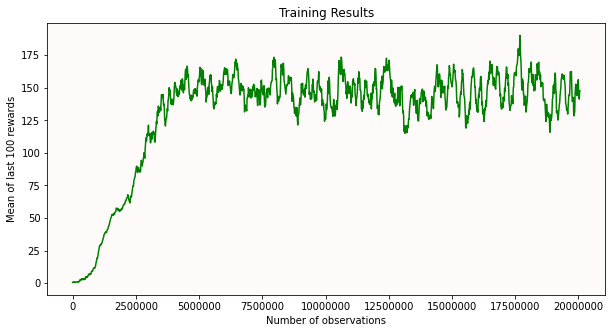

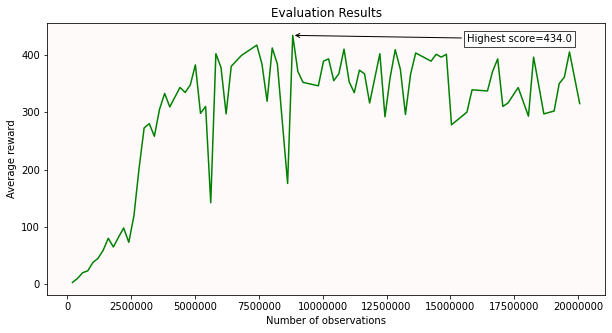

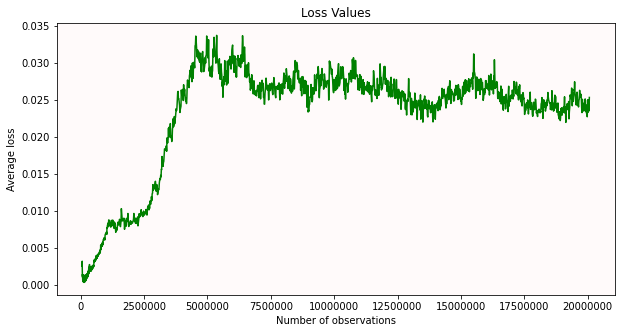

In [117]:
# Training duration.
print("Training duration: {:3.2f}".format((end - start).total_seconds()/3600),
      "hours")

# Plot results.
# Training results.
plt.figure(figsize=(10, 5))
plt.gca().set_facecolor("snow")
plt.ticklabel_format(style="plain", useOffset=True)
plt.plot(training_observations, training_rewards, color="g")
plt.title("Training Results")
plt.xlabel("Number of observations")
plt.ylabel("Mean of last 100 rewards")
plt.show()

# Evaluation results.
plt.figure(figsize=(10, 5))
plt.gca().set_facecolor("snow")
plt.ticklabel_format(style="plain", useOffset=True)
xmax = evaluation_observations[np.argmax(evaluation_rewards)]
ymax = np.max(evaluation_rewards)
text = "Highest score={}".format(ymax)
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
arrowprops = dict(arrowstyle="->")
kw = dict(xycoords='data',textcoords="axes fraction",
          arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
plt.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)
plt.plot(evaluation_observations, evaluation_rewards, color="g")
plt.title("Evaluation Results")
plt.xlabel("Number of observations")
plt.ylabel("Average reward")
plt.show()

# Loss values.
plt.figure(figsize=(10, 5))
plt.gca().set_facecolor("snow")
plt.ticklabel_format(style="plain", useOffset=True)
plt.plot(losses_observations, losses, color="g")
plt.title("Loss Values")
plt.xlabel("Number of observations")
plt.ylabel("Average loss")
plt.show()